In [1]:
%pylab inline
#%config InlineBackend.figure_format = 'retina' 

Populating the interactive namespace from numpy and matplotlib


In [10]:
#here are some common modules:
import scipy as sp #library of scientific functions
import scipy.io 
import scipy.signal as signal
import numpy as np #library of math functions
import pandas as pd #library of data analysis functions
import matplotlib.pyplot as plt #functions to plot data
import os #This lets python talk to your opperating system to open and save files.
from parabolic import parabolic

In [11]:
filename = 'emodat.mat' #adjut file name here
filename = os.path.join('../FM-BCI', filename) #adjust filepath 
datafile = sp.io.loadmat(filename) #loading filename
#print datafile.keys()
voltageSamples = datafile['data'] 
#print voltageSamples.shape, len(voltageSamples)

In [12]:
variances = []
means = []
medians = []
standardDeviations = []
for i in range(len(voltageSamples)):
    variances.append(np.var(voltageSamples[i,:]))
    means.append(np.mean(voltageSamples[i,:]))
    medians.append(np.median(voltageSamples[i,:]))
    standardDeviations.append(np.std(voltageSamples[i,:]))

In [13]:
for i in range(len(voltageSamples)):
    print 'Channel', i+1
    print '\tmean:', means[i]
    print '\tmedian:', medians[i]
    print '\tstandard deviation:', standardDeviations[i]
    print '\tvariance:', np.var(voltageSamples)

Channel 1
	mean: 53.5051604742
	median: 8.42684103561
	standard deviation: 105.317167517
	variance: 11091.7057739


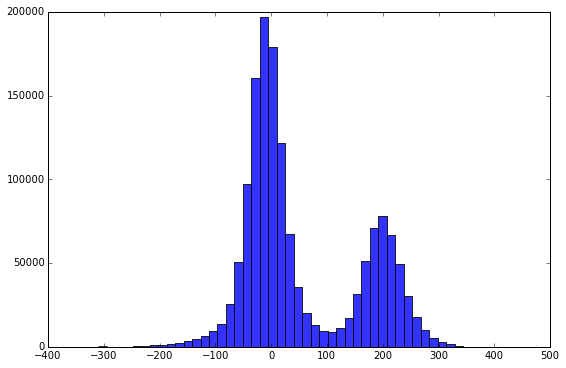

In [14]:
fig1 = plt.figure(1, figsize=(9,6))
numBins = 50
n, bins, patches = plt.hist(voltageSamples[0],numBins,alpha=0.8)


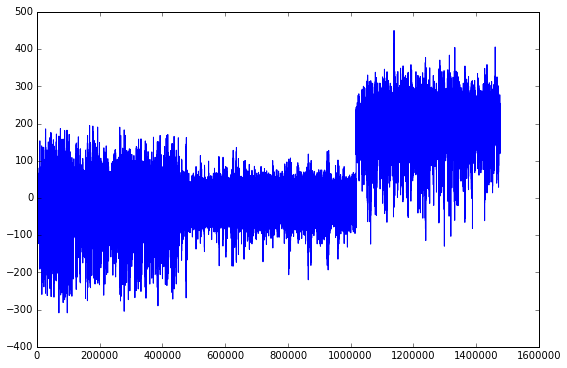

In [15]:
fig2 = plt.figure(2, figsize=(9,6))
plt.plot(voltageSamples[0])

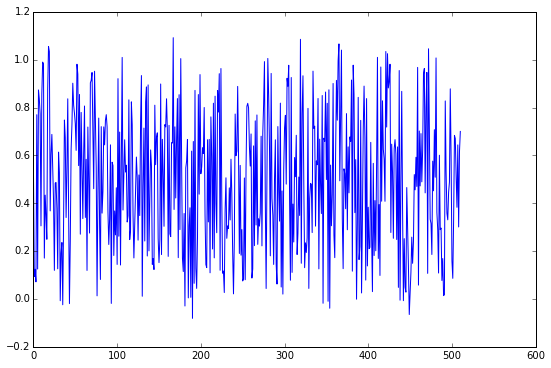

In [54]:
sampleRate = 512 # sample rate assumed during recording
sampleSpacing = 1.0 / sampleRate # time between samples in seconds
dataLengthSecs = 60 # length of whole recording
dataLengthSamples = dataLengthSecs*sampleRate # length of whole recording in samples

t = np.arange(0,dataLengthSecs,sampleSpacing) # time vector spanning length in seconds, with approp. num of samples
alpha = 0.1*np.sin(10.0 * 2.0 * np.pi * t) # generate fake alpha rhythm with amplitude 0.1
noise = np.random.random([1,dataLengthSamples]) # generate random vector of amplitude 1, 1:10 signal:noise ratio
voltageSamples = alpha+noise # mix signals
numOfChannel = voltageSamples.shape[0] # determine number of channels from data, i.e. not predefined

fig3 = plt.figure(3, figsize=(9,6))
plt.plot(voltageSamples[0,1:sampleRate]) # plots 1 second of data

In [68]:
channelPeaks = np.empty([numOfChannel, dataLengthSecs]) # container for peak frequencies for each channel every second
winLengthSecs = 0.125 # predefine length of window
winLengthSamples = winLengthSecs*sampleRate # length of window in samples
numOfWindows = int(dataLengthSamples/winLengthSamples) # determine number of windows
for channelIndex in range(0,numOfChannel):
    for winIndex in range(0,numOfWindows):
        
        # get next window of data, detrend
        channelVoltageWin = voltageSamples[channelIndex,winIndex*winLengthSecs*sampleRate:(winIndex+1)*winLengthSecs*sampleRate] \
        - np.mean(voltageSamples[channelIndex,winIndex*winLengthSecs*sampleRate:(winIndex+1)*winLengthSecs*sampleRate])
        
        # window next window of data
        winLengthSamples = len(channelVoltageWin) # determine window length
        #windowed = channelVoltage * signal.blackmanharris(winLengthSamples)
        windowedWin = channelVoltageWin * signal.gaussian(winLengthSamples, std=8,sym=False)

        # compute fft
        desiredFreqResolution = 0.1 # predefine resolution of spectrum
        paddingMultiple = 1/desiredFreqResolution
        fftLengthSamples = winLengthSamples*int(paddingMultiple) # determine fft length from that
        nyq = 0.5*sampleRate # maximum possible frequency to measure
        amp = abs(scipy.fftpack.rfft(channelVoltageWin,fftLengthSamples)) # determine amplitude spectrum by taking abs
        freqs = scipy.fftpack.rfftfreq(fftLengthSamples,sampleSpacing) # retrieve frequency axis

        # find peak frequency
        maxAmplitudeIndex = np.argmax(amp) # finds simple max amp peak
        true_maxAmplitudeIndex = parabolic(np.log(amp), maxAmplitudeIndex-1)[0] # finds parabolic interpolation
        maxFreq = freqs[maxAmplitudeIndex] # retrieves frequency of peak
        true_maxFreq = nyq * true_maxAmplitudeIndex / fftLengthSamples # retrieves frequency of parabolic peak
        print('Channel '+str(channelIndex+1)+ ', Window '+str(winIndex+1)+':     '+str(true_maxFreq)+'  '+str(maxFreq))
        channelPeaks[channelIndex,secondIndex] = true_maxFreq # stores peak frequency for every window


Channel 1, Window 1:     14.399906474  15.2
Channel 1, Window 2:     115.188426874  116.0
Channel 1, Window 3:     205.599461506  206.4
Channel 1, Window 4:     45.1956583978  45.6
Channel 1, Window 5:     20.7989931438  21.6
Channel 1, Window 6:     244.391505681  244.8
Channel 1, Window 7:     11.9899005072  12.8
Channel 1, Window 8:     11.1958771341  12.0
Channel 1, Window 9:     83.9963586412  84.8
Channel 1, Window 10:     10.3992303529  11.2
Channel 1, Window 11:     19.1968598708  20.0
Channel 1, Window 12:     8.79975585256  9.6
Channel 1, Window 13:     255.195621926  256.0
Channel 1, Window 14:     10.7960340037  11.2
Channel 1, Window 15:     97.9992364991  98.4
Channel 1, Window 16:     8.79768327601  9.6
Channel 1, Window 17:     193.998956246  194.4
Channel 1, Window 18:     180.399300108  180.8
Channel 1, Window 19:     127.998379149  128.8
Channel 1, Window 20:     197.994413664  198.4
Channel 1, Window 21:     111.199127655  112.0
Channel 1, Window 22:     216.3874007

In [69]:
print np.median(channelPeaks)
print np.mean(channelPeaks)

10.0098814458
15.1095433118
